In [7]:
# Cell 1: Install and import SHAP
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Install SHAP if not already installed
try:
    import shap
    print("SHAP imported successfully")
except ImportError:
    print("Installing SHAP...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

# Configure SHAP for VS Code
shap.initjs()

print(f"SHAP version: {shap.__version__}")


SHAP imported successfully


SHAP version: 0.48.0


In [8]:
# Cell 2: Load data and train model
# Load our biased dataset
loan_data = pd.read_csv('../data/loan_dataset_with_gender_bias.csv')

# Prepare features and target
feature_columns = ['age', 'income', 'credit_score']
X = loan_data[feature_columns]
y = loan_data['approved']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train models for comparison
print("Training models...")

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print(f"Logistic Regression accuracy: {lr_model.score(X_test, y_test):.3f}")
print(f"Random Forest accuracy: {rf_model.score(X_test, y_test):.3f}")


Training models...
Logistic Regression accuracy: 0.713
Random Forest accuracy: 0.743


=== SHAP Analysis for Logistic Regression ===


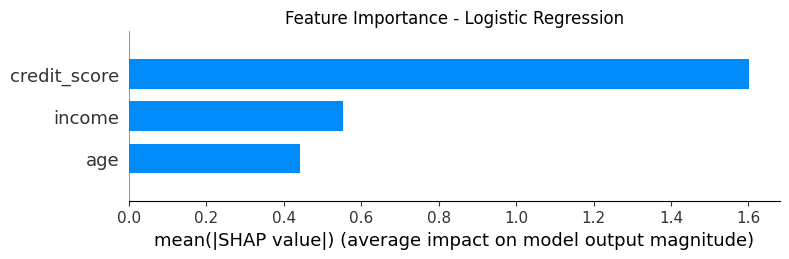

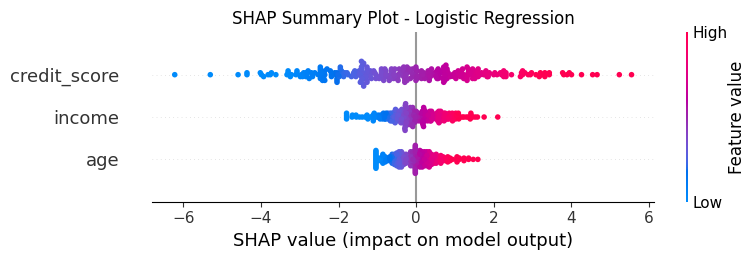

In [9]:
# Cell 3: SHAP Analysis for Logistic Regression
print("=== SHAP Analysis for Logistic Regression ===")

# Create SHAP explainer
lr_explainer = shap.LinearExplainer(lr_model, X_train)
lr_shap_values = lr_explainer.shap_values(X_test)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(lr_shap_values, X_test, plot_type="bar", show=False)
plt.title("Feature Importance - Logistic Regression")
plt.tight_layout()
plt.show()

# Detailed summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(lr_shap_values, X_test, show=False)
plt.title("SHAP Summary Plot - Logistic Regression")
plt.tight_layout()
plt.show()


=== SHAP Analysis for Random Forest ===


<Figure size 1000x600 with 0 Axes>

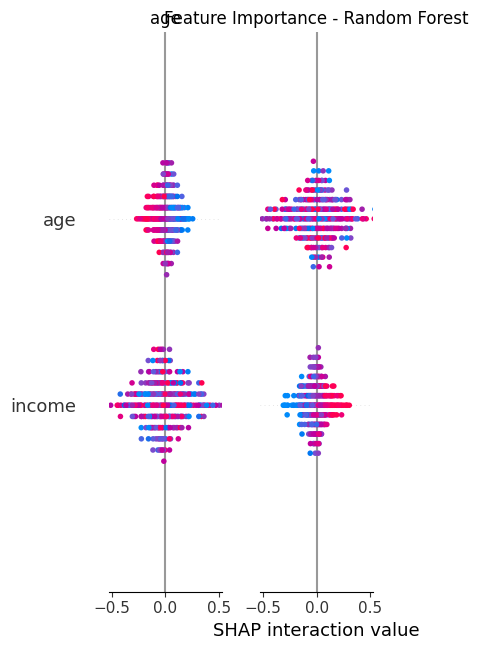

<Figure size 1000x600 with 0 Axes>

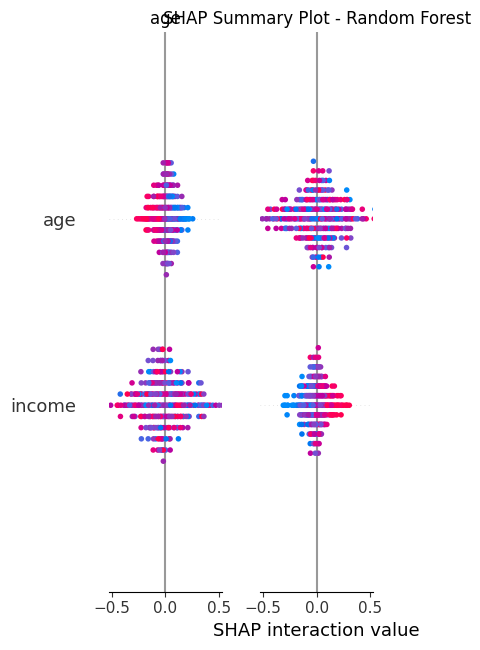

In [16]:
# Cell 4: SHAP Analysis for Random Forest
print("=== SHAP Analysis for Random Forest ===")

rf_explainer = shap.Explainer(rf_model, X_train)
rf_shap_values = rf_explainer(X_test)  # Returns Explanation object
 # → List of 2 arrays for binary classification



# For binary classification, take the positive class
if len(rf_shap_values) == 2:
    rf_shap_values = rf_shap_values[1]

# Summary plots
plt.figure(figsize=(10, 6))
shap.summary_plot(rf_shap_values, X_test, plot_type="bar", show=False)
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(rf_shap_values, X_test, show=False)
plt.title("SHAP Summary Plot - Random Forest")
plt.tight_layout()
plt.show()


=== Individual Prediction Explanations ===

--- Sample 1 ---
Features: Age=25, Income=$55,717, Credit=667
Actual: 1, Predicted: 0, Probability: 0.410


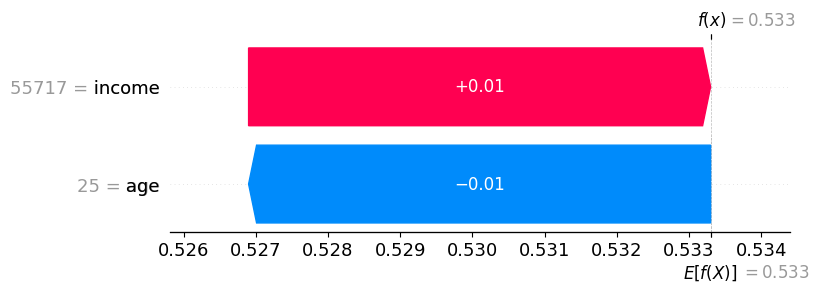


--- Sample 2 ---
Features: Age=18, Income=$70,701, Credit=661
Actual: 1, Predicted: 0, Probability: 0.210


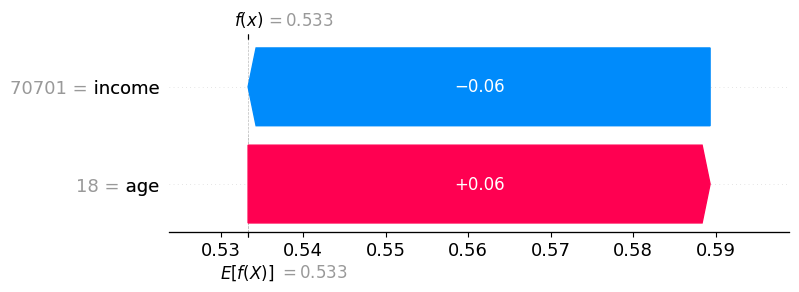


--- Sample 3 ---
Features: Age=40, Income=$58,731, Credit=850
Actual: 1, Predicted: 1, Probability: 0.920


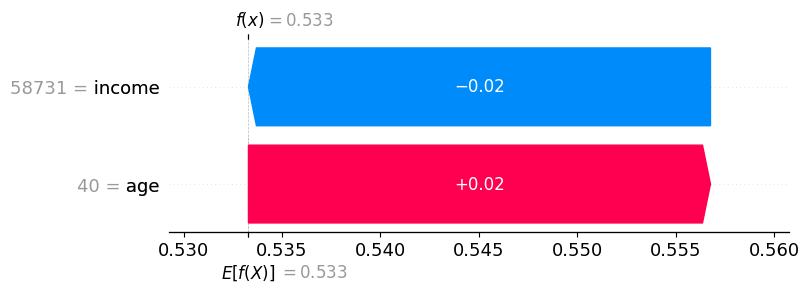


--- Sample 4 ---
Features: Age=19, Income=$47,749, Credit=662
Actual: 1, Predicted: 1, Probability: 0.700


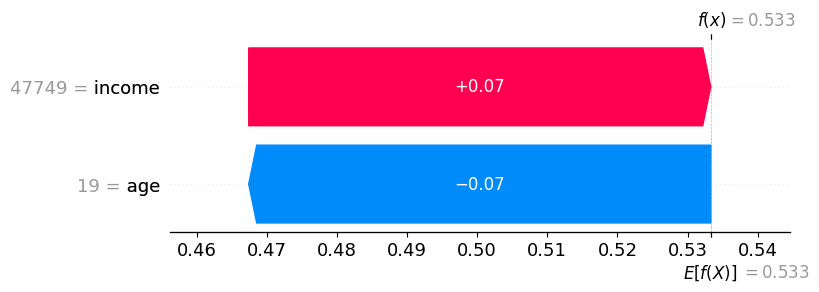


--- Sample 5 ---
Features: Age=37, Income=$58,287, Credit=651
Actual: 1, Predicted: 0, Probability: 0.500


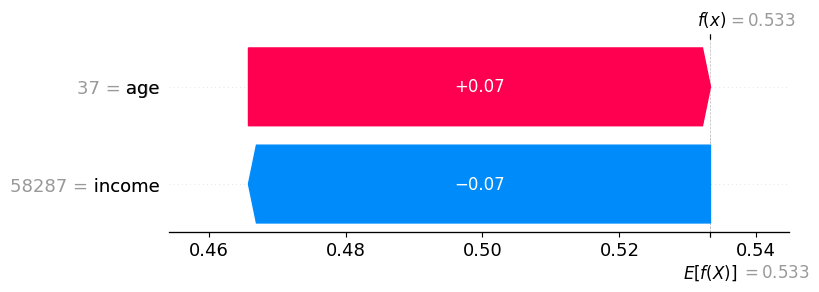

In [19]:
print("=== Individual Prediction Explanations ===")

sample_indices = [0, 1, 2, 5, 10]

for i, idx in enumerate(sample_indices):
    sample = X_test.iloc[idx:idx+1]
    actual = y_test.iloc[idx]
    
    rf_pred = rf_model.predict(sample)[0]
    rf_prob = rf_model.predict_proba(sample)[0][1]
    
    print(f"\n--- Sample {i+1} ---")
    print(f"Features: Age={sample['age'].values[0]:.0f}, Income=${sample['income'].values[0]:,.0f}, Credit={sample['credit_score'].values[0]:.0f}")
    print(f"Actual: {actual}, Predicted: {rf_pred}, Probability: {rf_prob:.3f}")
    
    # Extract only class 1 explanation properly from multi-output
    sample_exp = rf_shap_values[idx]
    sample_exp_class1 = shap.Explanation(
        values=sample_exp.values[1],
        base_values=sample_exp.base_values[1],
        data=sample_exp.data,
        feature_names=sample_exp.feature_names
    )
    
    # Plot
    shap.plots.waterfall(
        shap_values=sample_exp_class1,
        max_display=10,
        show=True
    )
